# SAM Exploration

## Dependencies

### GPU

In [1]:
!nvidia-smi

Mon Dec 11 16:42:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Libraries

In [2]:
!pip install jupyter_bbox_widget supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.5 MB/s eta 0:00:00


In [3]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-w6pzg8n3
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-w6pzg8n3
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=ad245722ba3822dca7bd9d50ea2329ed80742614775ce91ab243fa8b504a1417
  Stored in directory: /tmp/pip-ephem-wheel-cache-5lsdgxrq/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [91]:
import os
import cv2
import torch
import base64
import numpy as np
import pandas as pd
import supervision as sv
import matplotlib.pyplot as plt

from google.colab import drive
from google.colab import output
from jupyter_bbox_widget import BBoxWidget
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

### Working Folder Setup

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Root folder in Google Drive for this project
DRIVE_BASE_PATH = '/content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2'

## Global Variables

In [16]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [4]:
WEIGHTS_PATH = '/content/weights'
WEIGHTS_FILE = 'sam_vit_h_4b8939.pth'
!mkdir {WEIGHTS_PATH}
!wget https://dl.fbaipublicfiles.com/segment_anything/{WEIGHTS_FILE} -P {WEIGHTS_PATH}

--2023-12-11 16:44:08--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.19, 3.162.163.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘/content/weights/sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   235MB/s    in 14s     

2023-12-11 16:44:22 (179 MB/s) - ‘/content/weights/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [8]:
# Seaview Point Labels
SEAVIEW_PL_IMAGES_PATH = os.path.join(DRIVE_BASE_PATH, 'data', 'benthic_datasets', 'point_labels', 'SEAVIEW')
SEAVIEW_PL_LABELS_PATH = os.path.join(DRIVE_BASE_PATH, 'data', 'benthic_datasets', 'point_labels', 'SEAVIEW', 'tabular-data')
REGIONS = {
    1: 'ATL', 2: 'IND_CHA', 3: 'IND_MDV', 4: 'PAC_AUS', 5: 'PAC_USA',
    6: 'PAC_IDN_PHL', 7: 'PAC_SLB', 8: 'PAC_TWN', 9: 'PAC_TLS',
    }

In [12]:
# path to store point label wise label comparison results
REEF_SUPPORT_POINT_LABELS_PATH = os.path.join(DRIVE_BASE_PATH, 'data', 'DATA-REEF-SUPPORT-POINT-LABELS-v1.csv')

In [13]:
IMAGES_PATH = os.path.join('/content', 'images')

In [92]:
RS_POINT_LABELS_DF = pd.read_csv(REEF_SUPPORT_POINT_LABELS_PATH, header='infer')
print(f"Shape of Point Labels: {RS_POINT_LABELS_DF.shape}")

Shape of Point Labels: (189370, 14)


In [93]:
RS_POINT_LABELS_DF.sample(2)

quadratid    y    x             label_name     label  func_group  \
100983  15026127001  921  639  Acroporidae branching   ACR-BRA  Hard Coral   
146722  38037022601  705  399   Porites lobata/lutea  POR-MASS  Hard Coral   

        method data_set   region seaview_class_name  seaview_class_label  \
100983  target    train  PAC_AUS         Hard Coral                    1   
146722  random    train  PAC_USA         Hard Coral                    1   

       reef_support_class_name  reef_support_class_label  \
100983              Hard Coral                         1   
146722              Hard Coral                         1   

       class_label_comparison  
100983                  Match  
146722                  Match

## Sample Selection

In [95]:
samples = [1, 32028198201]
sample = samples[1]
print(f"Image sample: {sample}.jpg")

if sample < 10:
    image_path = os.path.join(IMAGES_PATH, '1.jpg')
    print(f"Image will be read from: {image_path}")
else:
    # read original image from seaview folders
    seaview_folder = RS_POINT_LABELS_DF.query(f"quadratid == {sample}").region.to_list()[0]
    image_path = os.path.join(SEAVIEW_PL_IMAGES_PATH, seaview_folder, f"{sample}.jpg")

Image sample: 32028198201.jpg


In [96]:
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
print(f"Shape of image: {image_rgb.shape}")

Shape of image: (1084, 1084, 3)


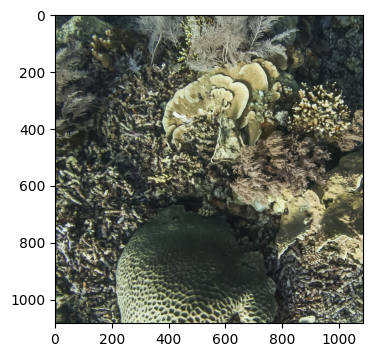

In [97]:
plt.figure(figsize=(4,4))
plt.imshow(image_rgb)
plt.show()

## Load SAM Model

In [17]:
sam = \
    sam_model_registry[MODEL_TYPE](
        checkpoint=os.path.join(WEIGHTS_PATH, WEIGHTS_FILE)
        ).to(device=DEVICE)

## Auto Mask Generation

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

### Run SAM (Auto Mode)

In [27]:
auto_mask_generator = SamAutomaticMaskGenerator(sam)

In [98]:
sam_auto_result = auto_mask_generator.generate(image_rgb)

In [121]:
auto_masks = np.array([x['segmentation'] for x in sam_auto_result])
merged_mask = \
    np.any(
        auto_masks.reshape(auto_masks.shape[0], -1),
        axis=0
        ).reshape(image_rgb.shape[:2])

In [127]:
print(f"Type of output: {type(sam_auto_result)}")
print(f"Type of each element: {type(sam_auto_result[0])}")
print(f"Keys of dict: {sam_auto_result[0].keys()}")
print(f"Number of masks: {len(sam_auto_result)}")
print(f"Mask Coverage: ",
    f"{round(np.sum(merged_mask) * 100 / (image_rgb.shape[0]*image_rgb.shape[1]), 2)} %")

Type of output: <class 'list'>
Type of each element: <class 'dict'>
Keys of dict: dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
Number of masks: 113
Mask Coverage:  53.23 %


### Visualize Results

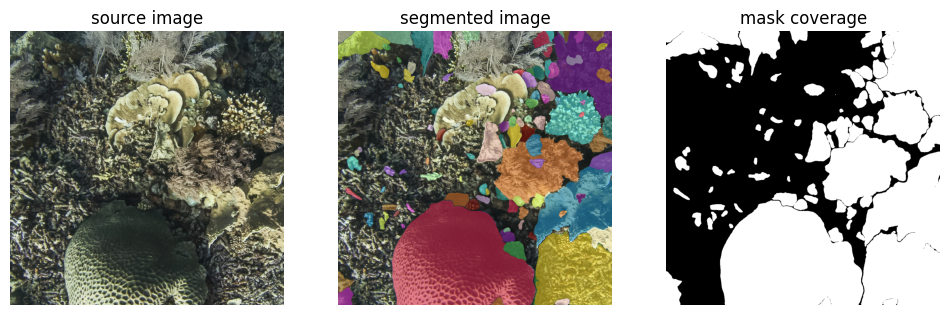

In [125]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_auto_result)
annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image, merged_mask],
    grid_size=(1, 3),
    titles=['source image', 'segmented image', 'mask coverage']
)

### View Masks Output

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_auto_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 8)+1),
    size=(16, 16)
)

## BBox Prompting

### Draw & Pick BBox

In [37]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded_image = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64," + encoded_image

In [129]:
output.enable_custom_widget_manager()
bbox_widget = BBoxWidget()
bbox_widget.image = encode_image(image_path)
bbox_widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [130]:
print(f"Details of selected boxes:")
print(f"{bbox_widget.bboxes}")

Details of selected boxes:
[{'x': 319, 'y': 113, 'width': 545, 'height': 412, 'label': ''}]


### Reformat BBox Data

In [143]:
bbox = bbox_widget.bboxes[0]
bbox = np.array([
    bbox['x'],
    bbox['y'],
    bbox['x'] + bbox['width'],
    bbox['y'] + bbox['height']
])
print(f"BBox: {bbox}")

BBox: [319 113 864 525]


### Run SAM (BBox Prompt)

In [45]:
mask_predictor = SamPredictor(sam)

In [140]:
mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=bbox,
    multimask_output=True
)

print(f"Shape of Masks: {masks.shape}")
print(f"Scores: {scores}")
print(f"Shape of Logits: {logits.shape}")

Shape of Masks: (3, 1084, 1084)
Scores: [0.9614128  0.97266245 0.9456035 ]
Shape of Logits: (3, 256, 256)


### Visualize Results

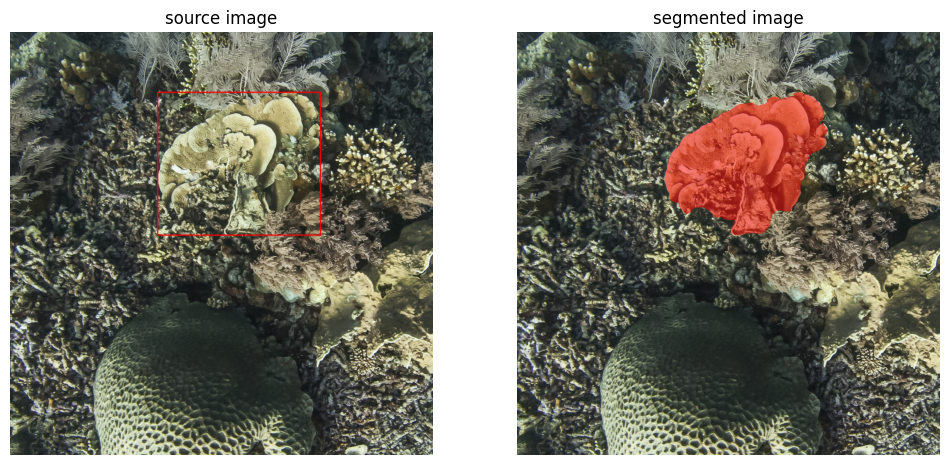

In [141]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### View Masks Output

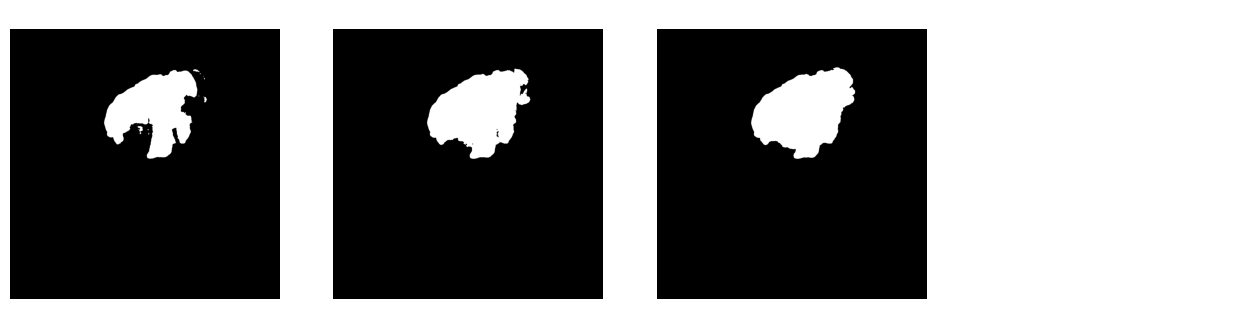

In [142]:
sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)

## Point Prompting

### Pick A Point (Single Click)

In [170]:
output.enable_custom_widget_manager()
point_widget = BBoxWidget()
point_widget.image = encode_image(image_path)
point_widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [232]:
print(f"Details of selected boxes:")
print(f"{point_widget.bboxes}")

Details of selected boxes:
[{'x': 458, 'y': 866, 'width': 0, 'height': 21, 'label': ''}]


### Extract Point(s)

In [233]:
point_coords = []
point_labels = []

In [234]:
for box in point_widget.bboxes:
    point_coords.append([box['x'], box['y']])
    point_labels.append(1)

print(f"Points Coordinates (x,y): {point_coords}")
print(f"Point Labels: {point_labels}")

Points Coordinates (x,y): [[458, 866]]
Point Labels: [1]


### Run SAM (Points Prompt)

In [62]:
mask_predictor = SamPredictor(sam)

In [235]:
mask_predictor.set_image(image_rgb)

point_masks, point_scores, point_logits = mask_predictor.predict(
    point_coords=np.array(point_coords),
    point_labels=np.array(point_labels),
    multimask_output=False
)

print(f"Shape of Masks: {point_masks.shape}")
print(f"Scores: {point_scores}")
print(f"Shape of Logits: {point_logits.shape}")

Shape of Masks: (1, 1084, 1084)
Scores: [0.98825455]
Shape of Logits: (1, 256, 256)


### Visualize Results

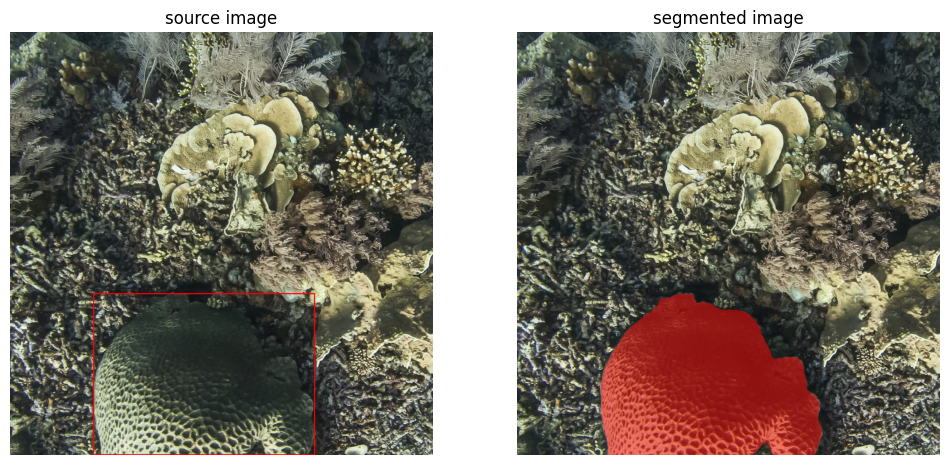

In [236]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=point_masks),
    mask=point_masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### View Masks Output

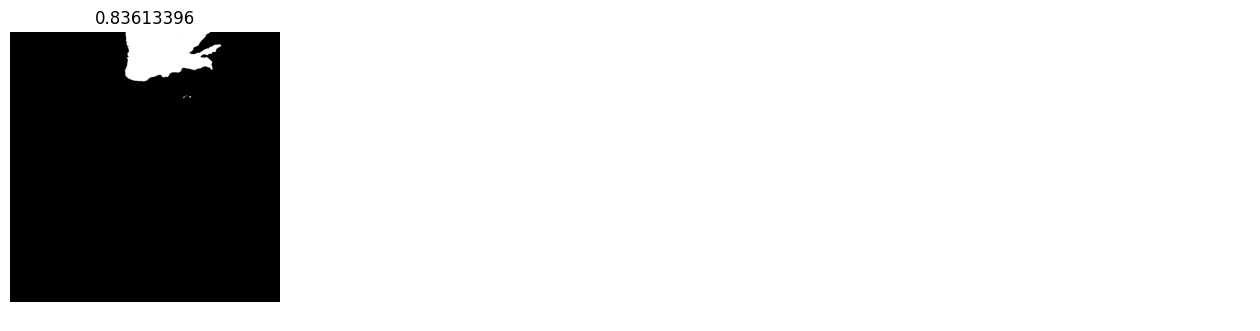

In [179]:
sv.plot_images_grid(
    images=point_masks,
    grid_size=(1, 4),
    size=(16, 4),
    titles=point_scores
)

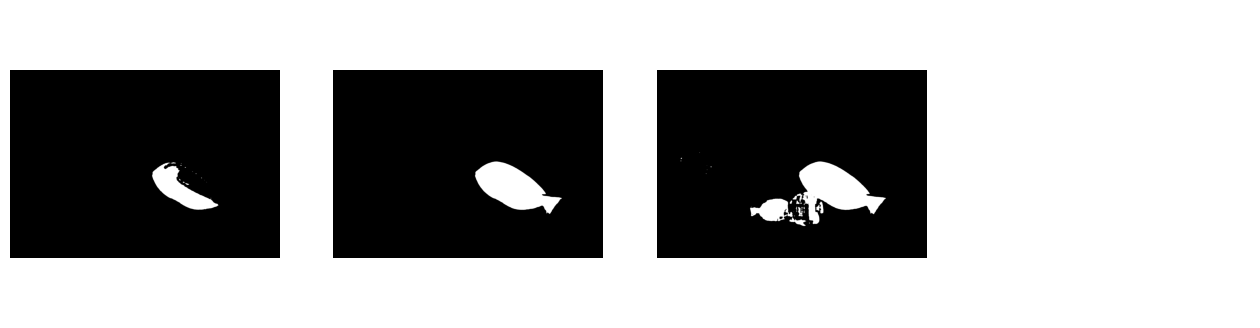

In [75]:
sv.plot_images_grid(
    images=point_masks,
    grid_size=(1, 4),
    size=(16, 4)
)